### Implements algorithm 1 in the parti-game [paper](https://link.springer.com/content/pdf/10.1007/BF00993591.pdf)

Learn a controller from a start region to a goal region on a continuous space; Four increasingly effective algorithms to partition discrete state spaces. Algorithm 1 and 2 are non-learning; 3 and 4 learn, hence explore, the world while planning a route to the goal. Here, I implement algorithm 1

In [2]:
import sys
import numpy as np
from os.path import abspath, join
sys.path.append(abspath(join('..')))
sys.path.append(abspath(join('..', 'grids')))
sys.path.append(abspath(join('..', 'utils')))
sys.path.append(abspath(join('..', 'Visualization')))
sys.path.append(abspath(join('..')))

from grids import *
import matplotlib.pyplot as plt
from gen_utils import *
from BoundaryCondition import *
from Visualization import Visualizer
from valFuncs import proj
%matplotlib inline

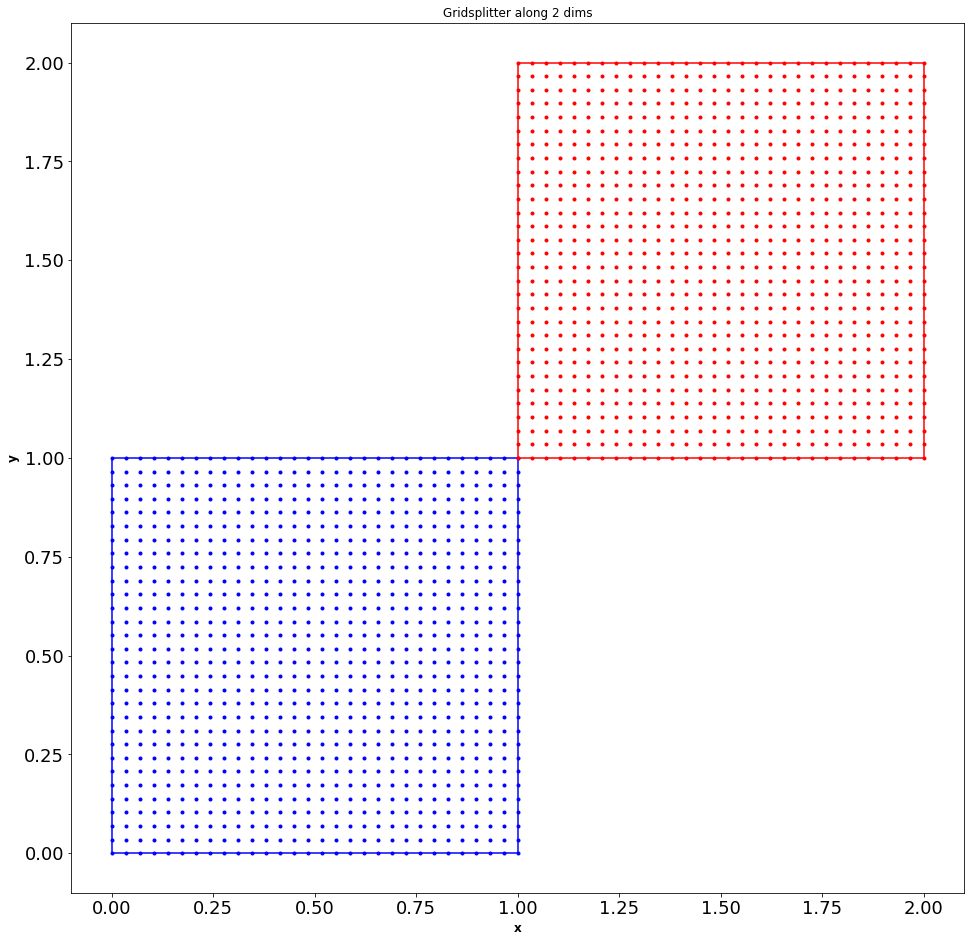

In [3]:
# this is same as sepGrid_test
num_points=30
gridIn=expand(np.array((0, 1, 0, 1)), 1)
gridOut =expand(np.array((1, 2, 1, 2)), 1)
N = num_points*ones(4,1).astype(np.int64)
g = createGrid(gridIn, gridOut, N, process=True, low_mem=True);

# print(f'len(g.xs), g.xs[0].shape {len(g.xs), g.xs[0].shape} g.N {g.N.shape}')
dims = [[0, 2], [1, 3]]

gs = sepGrid(g, dims);

# Visualize
viz = Visualizer(winsize=(16, 16))
viz.visGrid(gs, dim= len(gs))

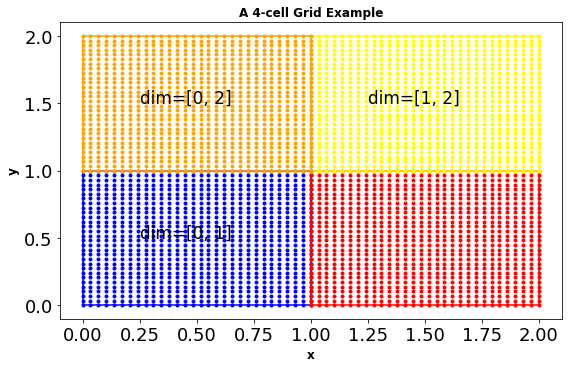

In [4]:
# 4 subcells grid
num_points=30
gridIn=expand(np.array((0, 1, 0, 1)), 1)
gridOut =expand(np.array((1, 2, 1, 2)), 1)
N = num_points*ones(4,1).astype(np.int64)
g = createGrid(gridIn, gridOut, N, process=True, low_mem=True);

# print(f'len(g.xs), g.xs[0].shape {len(g.xs), g.xs[0].shape} g.N {g.N.shape}')
dims = [[0, 2], [1, 2],  [1, 3], [0, 1]]

gs = sepGrid(g, dims);

viz = Visualizer(winsize=(8, 5))
ax = viz._fig.add_subplot(1, 1, 1)

# Visualize
colors = ['blue', 'red', 'yellow', 'orange', 'green', 'black']

i=0
for g in gs:
    ax.plot(g.xs[0], g.xs[1], '.', color=colors[i])
    ax.plot(np.hstack([g.min[0], g.min[0]]), np.hstack([g.min[1], g.max[1]]), linestyle='-', color=colors[i])
    ax.plot(np.hstack([g.max[0], g.max[0]]), np.hstack([g.min[1], g.max[1]]), linestyle='-', color=colors[i])
    ax.plot(np.hstack([g.min[0], g.max[0]]), np.hstack([g.min[1], g.min[1]]), linestyle='-', color=colors[i])
    ax.plot(np.hstack([g.min[0], g.max[0]]), np.hstack([g.max[1], g.max[1]]), linestyle='-', color=colors[i])

    ax.xaxis.set_tick_params(labelsize=viz._labelsize)
    ax.yaxis.set_tick_params(labelsize=viz._labelsize)

    ax.set_xlabel('x', fontdict=viz._fontdict)
    ax.set_ylabel('y', fontdict=viz._fontdict)
    x, y = dims[i]
    #print(dims[i])
    ax.annotate(f'dim={dims[i]}', xy=(x+0.25, y-0.5), size=17)
    i+=1
    
viz._fig.tight_layout()
plt.title(f'A {len(gs)}-cell Grid Example', fontdict=viz._fontdict)
plt.show()

In [4]:
x, y = -g.min+g.max/2
x, y

(array([0.5]), array([0.]))

In [5]:
## Cells Division Example | Lekan August 05

gridIn= expand(np.array((0, 1, 0, 1, 1, 2, 1, 2)), 1)
gridOut =expand(np.array((1, 2, 1, 2, 2, 3, 2, 3)), 1)

num_points = 30
N = num_points*ones(8,1).astype(np.int64)

g = createGrid(gridIn, gridOut, N, process=True);

dims = [[0, 2], [1, 2],  [1, 3], [0, 1]]
gs = sepGrid(g, dims);
len(gs)
viz = Visualizer(winsize=(8, 5))
ax = viz._fig.add_subplot(1, 1, 1)

colors = ['blue', 'red', 'yellow', 'orange', 'green', 'black', 'magenta', 'cyan', 'white']
i=0
for g in gs:
    ax.plot(g.xs[0], g.xs[1], '.', color=colors[i])
    ax.plot(np.hstack([g.min[0], g.min[0]]), np.hstack([g.min[1], g.max[1]]), linestyle='-', color=colors[i])
    ax.plot(np.hstack([g.max[0], g.max[0]]), np.hstack([g.min[1], g.max[1]]), linestyle='-', color=colors[i])
    ax.plot(np.hstack([g.min[0], g.max[0]]), np.hstack([g.min[1], g.min[1]]), linestyle='-', color=colors[i])
    ax.plot(np.hstack([g.min[0], g.max[0]]), np.hstack([g.max[1], g.max[1]]), linestyle='-', color=colors[i])

    ax.xaxis.set_tick_params(labelsize=viz._labelsize)
    ax.yaxis.set_tick_params(labelsize=viz._labelsize)

    ax.set_xlabel('x', fontdict=viz._fontdict)
    ax.set_ylabel('y', fontdict=viz._fontdict)
    
    x, y = dims[i]
    #print(dims[i])
    ax.annotate(f'dim={dims[i]}', xy=(x+0.25, y-0.5), size=17)
    i+=1
viz._fig.tight_layout()
plt.title(f'A {len(gs)}-cell Grid Example', fontdict=viz._fontdict)
plt.show()

Grid dimension > 5, may be dangerously large


MemoryError: Unable to allocate 4.77 TiB for an array with shape (30, 30, 30, 30, 30, 30, 30, 30) and data type float64

In [10]:
gg = g.vs[1]
gg.shape

(30, 1)

In [ ]:
from math import pi

grid_min = expand(np.array((-5, -5, -pi)), ax = 1); # Lower corner of computation domain
grid_max = expand(np.array((5, 5, pi)), ax = 1);   # Upper corner of computation domain
N = 41*np.ones((3, 1)).astype(int)                 # Number of grid points per dimension
pdDims = 3;                                        # 3rd dimension is periodic
g = createGrid(grid_min, grid_max, N, pdDims);

In [ ]:
viz = Visualizer(winsize=(30, 18), fontdict={'fontsize':30, 'fontweight':'bold'})
viz.visGrid(g, dim=pdDims)
print()

In [ ]:
gridIn=expand(np.array((0, 1, 0, 1)), 1)
gridOut =expand(np.array((1, 2, 1, 2)), 1)
N = 45*ones(4,1).astype(np.int64)

g = createGrid(gridIn, gridOut, N);

In [66]:
help(np.insert)

Help on function insert in module numpy:

insert(arr, obj, values, axis=None)
    Insert values along the given axis before the given indices.
    
    Parameters
    ----------
    arr : array_like
        Input array.
    obj : int, slice or sequence of ints
        Object that defines the index or indices before which `values` is
        inserted.
    
        .. versionadded:: 1.8.0
    
        Support for multiple insertions when `obj` is a single scalar or a
        sequence with one element (similar to calling insert multiple
        times).
    values : array_like
        Values to insert into `arr`. If the type of `values` is different
        from that of `arr`, `values` is converted to the type of `arr`.
        `values` should be shaped so that ``arr[...,obj,...] = values``
        is legal.
    axis : int, optional
        Axis along which to insert `values`.  If `axis` is None then `arr`
        is flattened first.
    
    Returns
    -------
    out : ndarray
        A

In [75]:
a = 2
b = np.arange(4).reshape(2,2)
c = b.flatten().tolist()
d = np.insert(a, 0, c)
print(d)
cn= min(np.insert(a, 0, c))
print(c, cn)

[0 1 2 3 2]
[0, 1, 2, 3] 0


In [ ]:
data = shapeCylinder(g, ignoreDims=np.random.rand(g.dim))

In [ ]:
g.xs[0].shape, g.dim, g.vs[0].shape

In [ ]:
help(np.meshgrid)

In [ ]:
res=np.random.rand(41,41,41)-5
Nshape = tuple(g.N.squeeze())
res.shape, g.shape, Nshape, Nshape+(1,), 

In [ ]:
def splitGrid(g, dims, bounds, padding=None):
    """
     gs = splitGrid(g, pieces, dims, padding, sizes)
         Splits a high-dimensional grid to a number of lower-dimensional grids
         See splitGrid_test() for an example

     Inputs:
         g - original grid
         dims   - cell vector of output grid dimensions
                  eg. dims = {[1; 3], [2; 4]} would produce two 2D sets of grids.
                      The first set has dimensions corresponding to the 1st and
                      3rd dimensions in the original grid
         bounds - list of bounds of the smaller grids. This should be a g.dim
                  dimensional matrix that specifies the "grid" of bounds.
             Example 1: suppose the original grid is a [-1, 1]^2 grid in 2D, and
                 dims = {[1 2]} (i.e. no lower-dimesional grids are created; all
                 grids remain in 2D). Then, the following bounds would split it
                 into [-1, 0]^2, [0, 1]^2, [-1, 0] x [0, 1], and [0, 1] x [-1, 0]
                 grids:
                     bounds = {[-1, 0, 1], [-1, 0, 1]};
             Example 2: uppose the original grid is a [-1, 1]^2 grid in 2D, and
                 dims = {[1], [2]} (i.e. split the grid into one-dimensional
                 grids). Then the following bounds would split it into [-1, 0], [0,
                 1] grids in the first dimension, and [-1, 0], [0, 1] grids in the
                 second dimension:
                     bounds = {[-1, 0, 1], [-1, 0, 1]};

         padding - amount of overlap between two adjacent subgrids

     Output:
       gs - cell vector of grids
     """

    if not padding:
        padding = 0.05 * (g.max - g.min);

    # Separate the grid into different dimensions
    gs_temp = sepGrid(g, dims);

    # For each dimension, split the grid according to bounds
    gs = []
    for i in range(gs_temp):
        gs.append(splitGrid_sameDim(gs_temp[i], bounds[dims[i]], padding(dims[i])))

    return gs

In [13]:
np.tile(':', (1,4))

array([[':', ':', ':', ':']], dtype='<U1')

In [26]:
Q = np.array(([1, 2, np.nan, np.inf]))
Q

array([ 1.,  2., nan, inf])

In [27]:
nanIdx = np.isinf(Q)

In [29]:
Q[nanIdx] = 1e6
Q

array([1.e+00, 2.e+00,    nan, 1.e+06])

In [13]:
list(range(0,1))

[0]

In [38]:
class Bundle(object):
    def __init__(self, dicko):
        for var, val in dicko.items():
            object.__setattr__(self, var, val)

    def __len__(self):
        return len(self.__dict__.keys())
    
A = Bundle(dict(a=1, b=2, c=3))    
len(A)

3

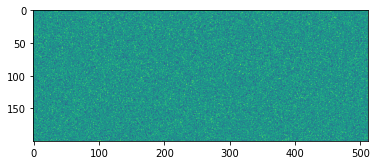

In [48]:
a = np.random.randn(200, 256)
b = np.random.randn(200, 256)
plt.imshow(np.hstack((a, b)))

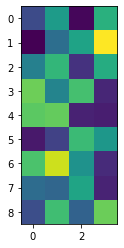

In [55]:
a = np.random.rand(3, 4)
b = np.random.rand(3, 4)
c = np.random.rand(3, 4)

cc = np.vstack((a, b, c))
plt.imshow(cc)
plt.show()

In [93]:
a = np.arange(64).reshape(4,4,4)
a

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]],

       [[16, 17, 18, 19],
        [20, 21, 22, 23],
        [24, 25, 26, 27],
        [28, 29, 30, 31]],

       [[32, 33, 34, 35],
        [36, 37, 38, 39],
        [40, 41, 42, 43],
        [44, 45, 46, 47]],

       [[48, 49, 50, 51],
        [52, 53, 54, 55],
        [56, 57, 58, 59],
        [60, 61, 62, 63]]])

In [105]:
a/2

array([[[ 0. ,  0.5,  1. ,  1.5],
        [ 2. ,  2.5,  3. ,  3.5],
        [ 4. ,  4.5,  5. ,  5.5],
        [ 6. ,  6.5,  7. ,  7.5]],

       [[ 8. ,  8.5,  9. ,  9.5],
        [10. , 10.5, 11. , 11.5],
        [12. , 12.5, 13. , 13.5],
        [14. , 14.5, 15. , 15.5]],

       [[16. , 16.5, 17. , 17.5],
        [18. , 18.5, 19. , 19.5],
        [20. , 20.5, 21. , 21.5],
        [22. , 22.5, 23. , 23.5]],

       [[24. , 24.5, 25. , 25.5],
        [26. , 26.5, 27. , 27.5],
        [28. , 28.5, 29. , 29.5],
        [30. , 30.5, 31. , 31.5]]])

In [106]:
np.divide(a, 2)

array([[[ 0. ,  0.5,  1. ,  1.5],
        [ 2. ,  2.5,  3. ,  3.5],
        [ 4. ,  4.5,  5. ,  5.5],
        [ 6. ,  6.5,  7. ,  7.5]],

       [[ 8. ,  8.5,  9. ,  9.5],
        [10. , 10.5, 11. , 11.5],
        [12. , 12.5, 13. , 13.5],
        [14. , 14.5, 15. , 15.5]],

       [[16. , 16.5, 17. , 17.5],
        [18. , 18.5, 19. , 19.5],
        [20. , 20.5, 21. , 21.5],
        [22. , 22.5, 23. , 23.5]],

       [[24. , 24.5, 25. , 25.5],
        [26. , 26.5, 27. , 27.5],
        [28. , 28.5, 29. , 29.5],
        [30. , 30.5, 31. , 31.5]]])

In [107]:
list(range(5))

[0, 1, 2, 3, 4]